In [104]:
import sys, os, time, pickle
from glob import glob
from timeit import default_timer as timer
from humanfriendly import format_timespan

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [106]:
%matplotlib inline

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [108]:
from pipeline_experiments import load_data_from_pickles, remove_missing_titles, year_lowpass_filter

In [109]:
from dotenv import load_dotenv
load_dotenv('admin.env')

True

In [110]:
from mysql_connect import get_db_connection
db = get_db_connection('jp_autoreview')

In [111]:
df = db.read_sql(db.tables['pipeline_tests'].select())
df.set_index('id', inplace=True)

In [112]:
top_results = df.sort_values('score_correctly_predicted', ascending=False).drop_duplicates(['review_paper_id', 'random_seed'])

In [113]:
sample_row = top_results.sample(n=1, random_state=999).iloc[0]

In [114]:
sample_row

datetime_added                                             2018-07-07 02:23:45
review_paper_id                                                     2298456115
random_seed                                                                  2
datadir                                        data/review_2298456115/seed_002
num_correctly_predicted                                                    198
num_target_papers                                                          658
num_target_in_candidates                                                   658
num_seed_papers                                                             50
score_correctly_predicted                                             0.300912
num_candidates                                                          485103
features                     ['avg_distance_to_train', 'ef', 'avg_title_tfi...
clf                          RandomForestClassifier(bootstrap=True, class_w...
clf_type                                            

In [115]:
start = timer()
data_dir = sample_row.datadir
test_papers, seed_papers, target_papers = load_data_from_pickles(data_dir)
print(format_timespan(timer()-start))

1.86 second


In [116]:
data_dir

'data/review_2298456115/seed_002'

In [117]:

target_ids = set(target_papers.Paper_ID)
test_papers['target'] = test_papers.Paper_ID.apply(lambda x: x in target_ids)
test_papers = remove_missing_titles(test_papers)
test_papers = year_lowpass_filter(test_papers, year=2009)

In [118]:
X = test_papers.reset_index()
y = X['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [119]:
from sklearn.metrics import average_precision_score, precision_recall_curve

In [120]:
model_fname = glob(os.path.join(data_dir, 'best_model*', '*.pickle'))[-1]
pipeline = joblib.load(model_fname)

/home/jporteno/code/autoreview/venv/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jporteno/code/autoreview/venv/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jporteno/code/autoreview/venv/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [121]:
start = timer()
y_score = pipeline.predict_proba(X_test)[:, 1]
print(format_timespan(timer()-start))

4.01 seconds


/home/jporteno/code/autoreview/utils/autoreview_utils.py:189: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return avg_dist.as_matrix().reshape(-1, 1)
/home/jporteno/code/autoreview/utils/autoreview_utils.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return df[self.colname].as_matrix().reshape(-1, 1)


In [122]:
start = timer()
average_precision = average_precision_score(y_test, y_score)
print(format_timespan(timer()-start))

0.01 seconds


In [123]:
start = timer()
precision, recall, threshold = precision_recall_curve(y_test, y_score)
print(format_timespan(timer()-start))

0.01 seconds


In [124]:
no_skill = (y==True).sum() / len(y)
no_skill

0.0011745154685440216

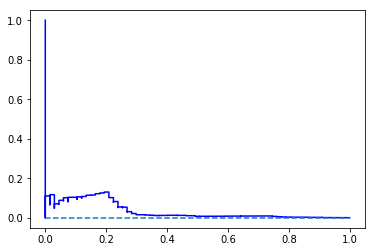

In [125]:
plt.step(recall, precision, color='b', where='post')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

Text(0.5,1,'2-class Precision-Recall curve: AP=0.03')

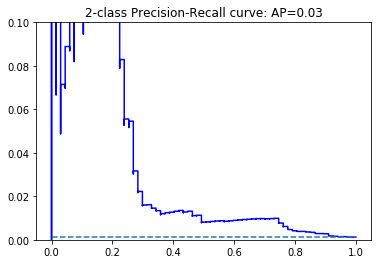

In [126]:
plt.step(recall, precision, color='b', where='post')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.ylim(0,.1)
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score

In [128]:
fpr, tpr, threshold = roc_curve(y_test, y_score)

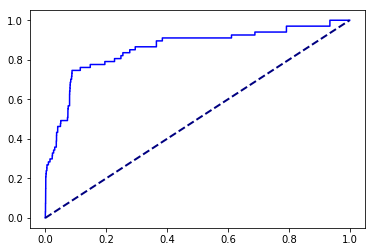

In [129]:
plt.step(fpr, tpr, color='b', where='post')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

In [130]:
roc_auc_score(y_test, y_score)

0.8633751282898924